### TensorFlow 및 기타 라이브러리 가져오기

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

print("tensorflow version",tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
tensorflow version 2.8.2


In [2]:
IMG_SIZE = 224 # 모든 이미지는 224x224으로 크기 조정 
EPOCHS = 3
BATCH_SIZE=128
learning_rate = 0.0001

### 데이터 세트 다운로드 및 탐색

In [3]:
from keras.datasets import cifar10
from keras.utils import np_utils
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#분류할 클래스 개수 
num_classes=10 # Cifar10의 클래스 개수

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cifar10',
    split=['train[:90%]', 'train[90%:]', 'test'],
    with_info=True,
    as_supervised=True,
)

print("Train data 개수:",len(raw_train))
print("Val data 개수:",len(raw_validation))
print("Test data 개수:",len(raw_test))

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Train data 개수: 45000
Val data 개수: 5000
Test data 개수: 10000


### 데이터 정규화(tf.image 모듈을 사용하여 이미지를 정규화)

In [4]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
# #map 함수를 사용하여 데이터셋의 각 항목에 데이터 포맷 함수를 적용
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

### 데이터 세트 만들기

In [6]:
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### 데이터 검사하기

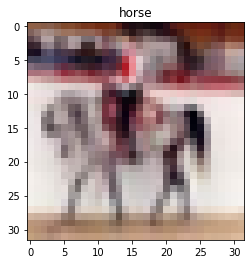

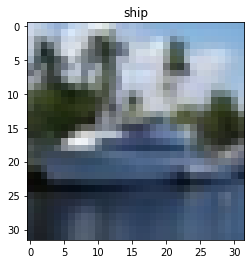

In [7]:
#데이터 가시화
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### 사용할 CNN 모델 불러오기

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#CNN 모델 변경하려면 여기서 변경
#ImageNet으로 사전 훈련된 모델 불러오기 
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=True,
                                                classes=1000,
                                               weights='imagenet')

553476096/553467096 [==============================] - 15s 0us/step


### 불러온 모델에서 데이터 셋의 클래스 수에 맞게 최종 분류층 교체

In [9]:
model = tf.keras.Sequential()
for layer in base_model.layers[:-1]: # go through until last layer
    model.add(layer)
#마지막 layer의 최종 분류 개수를 클래스 개수와 맞게 설정
model.add(keras.layers.Dense(num_classes, activation='softmax',name='predictions'))

### 모델 아키텍처 살펴보기

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### 모델 컴파일

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 모델 훈련

In [12]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    batch_size=BATCH_SIZE)

Epoch 1/3
352/352 [==============================] - 768s 2s/step - loss: 1.6017 - accuracy: 0.4207 - val_loss: 0.9331 - val_accuracy: 0.6696
Epoch 2/3
352/352 [==============================] - 719s 2s/step - loss: 0.6952 - accuracy: 0.7559 - val_loss: 0.6001 - val_accuracy: 0.7936
Epoch 3/3
352/352 [==============================] - 718s 2s/step - loss: 0.4417 - accuracy: 0.8454 - val_loss: 0.4679 - val_accuracy: 0.8380


### 학습 곡선 그리기

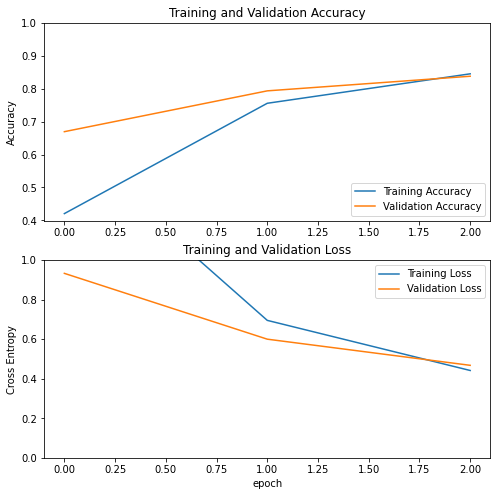

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Test Set으로 학습된 모델 테스트

In [14]:
loss_and_metrics = model.evaluate(test_batches, batch_size=64)
print("테스트 성능 : {}%".format(round(loss_and_metrics[1]*100,4)))

79/79 [==============================] - 54s 685ms/step - loss: 0.4864 - accuracy: 0.8347
테스트 성능 : 83.47%
